In [10]:
from src.pytorch_datasets import DAPSAudioDataset_with_cropping
import os
from torch.utils.data import DataLoader, Subset

import torch

audio_dir = "daps_2"

class_1_speakers = ["f1", "f7", "f8", "m3", "m6", "m8"]

class_mapping = {}

for root, dirs, files in os.walk('precomputed_spectrograms_aug'):
    for file in files:
        audio_path = os.path.join(root, file)
        try:
            speaker_prefix = file.split("_")[0]
            if speaker_prefix in class_1_speakers:
                class_mapping[audio_path] = 1
            else:
                class_mapping[audio_path] = 0
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")

print("Class mapping created:")

class_0_count = sum(1 for label in class_mapping.values() if label == 0)
class_1_count = sum(1 for label in class_mapping.values() if label == 1)
print(f"Total Class 0 samples: {class_0_count}")
print(f"Total Class 1 samples: {class_1_count}")
print("Preparing the dataset...")

full_dataset = DAPSAudioDataset_with_cropping(class_mapping=class_mapping)

test_ids =[]
train_ids =[]
filenames = set()
for idx in range(len(full_dataset)):
    path, label = full_dataset.class_mapping[idx]
    if path is not None:
        filename = os.path.basename(path)
            
        filename_without_ext = os.path.splitext(filename)[0]
        parts = filename_without_ext.split('_')
            
        group = parts[0]
        place = ""
        if 'script1' in filename_without_ext:
            if 'aug' not in filename_without_ext:
                filenames.add(place)
                test_ids.append(idx)
            else: 
                continue
        else:
            train_ids.append(idx) 
print(len(test_ids))
print(len(train_ids))

print("Dataset created")

train_dataset = Subset(full_dataset, train_ids)
test_dataset = Subset(full_dataset, test_ids)

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn
)

for batch in train_loader:
    inputs, labels = batch
    print(f"Train Inputs shape: {inputs.shape}")
    print(f"Train Labels: {labels}")
    break

for batch in test_loader:
    inputs, labels = batch
    print(f"Test Inputs shape: {inputs.shape}")
    print(f"Test Labels: {labels}")
    break

Class mapping created:
Total Class 0 samples: 1050
Total Class 1 samples: 900
Preparing the dataset...
300
1560
Dataset created
Train Inputs shape: torch.Size([64, 1, 64, 64])
Train Labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0])
Test Inputs shape: torch.Size([16, 1, 64, 64])
Test Labels: tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1])


In [11]:
import torch
import multiprocessing

torch.set_num_threads(4)

print("Nombre de cœurs physiques:", multiprocessing.cpu_count())

logical_cores = torch.get_num_threads()
print("Nombre de cœurs logiques (threads disponibles):", logical_cores)

Nombre de cœurs physiques: 12
Nombre de cœurs logiques (threads disponibles): 4


In [12]:
train_loader

Epoch 1/3, start training...
Epoch [1/3], Loss: 0.9677
Epoch 2/3, start training...
Epoch [2/3], Loss: 0.7289
Epoch 3/3, start training...
Epoch [3/3], Loss: 0.6680


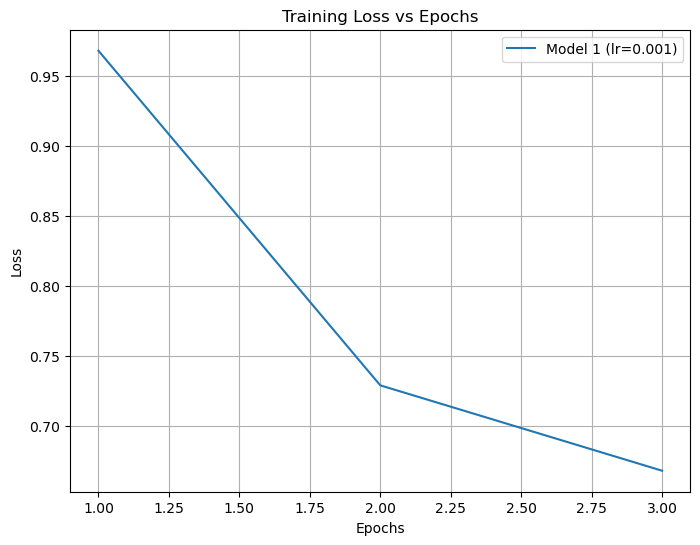

In [13]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


freq_bins = 64
time_steps = 64
lr = 0.001

model = Net(freq_bins, time_steps).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


num_epochs = 3
batch_size = 32  

optimizer_name = type(optimizer).__name__

metadata = {
    "model": str(model),
    "freq_bins": freq_bins,
    "time_steps": time_steps,
    "batch_size": batch_size,
    "train_set_size": len(train_loader.dataset),
    "optimizer": optimizer_name,
    "loss_function": str(criterion),
    "num_epochs": num_epochs,
}

timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
results_path = f"models_results/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
os.makedirs(os.path.dirname(results_path), exist_ok=True)


training_results = {"metadata": metadata, "data": {}}


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}, start training...")
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    epoch_data = {"loss": avg_loss, "lr": optimizer.param_groups[0]["lr"]}
    training_results["data"][str(epoch + 1)] = epoch_data

    with open(results_path, "w") as f:
        json.dump(training_results, f, indent=4)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


fig, ax = plt.subplots(figsize=(8, 6))


plot_training_results(ax, results_path, label_prefix="Model 1")


plt.title("Training Loss vs Epochs")
plt.show()

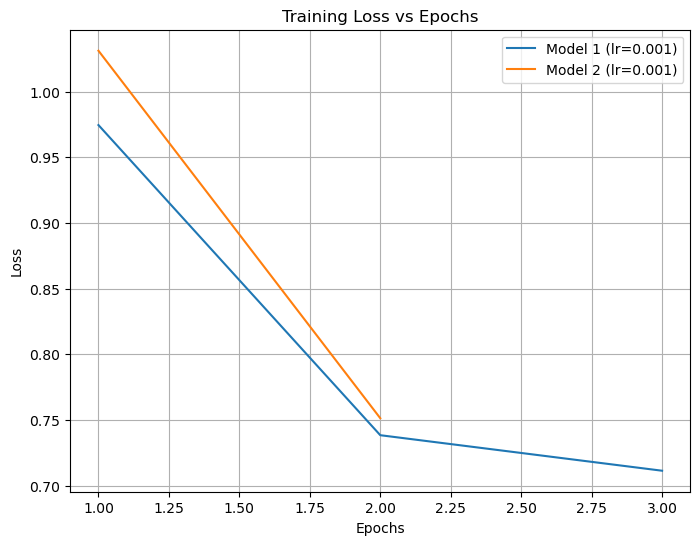

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "3x0.001xAdamx1920_13-12-02-10-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Model 1")
results_path = "models_results/" + "2x0.001xAdamx1920_55-05-02-10-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Model 2")


plt.title("Training Loss vs Epochs")
plt.show()

In [15]:
len(train_loader.dataset)

1560

In [16]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_bins = 64
time_steps = 64

# Configurations for your task
configs = [
    {"lr": 0.0001, "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)},
    {"lr": 0.001, "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001, momentum=0.9)},
]

num_epochs = 30
batch_size = 32

# Loop over configurations
for config in configs:
    lr = config["lr"]
    optimizer = config["optimizer"]

    model = Net(freq_bins, time_steps).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_instance = optimizer(model)

    optimizer_name = type(optimizer_instance).__name__

    metadata = {
        "model": str(model),
        "freq_bins": freq_bins,
        "time_steps": time_steps,
        "batch_size": batch_size,
        "optimizer": optimizer_name,
        "loss_function": str(criterion),
        "num_epochs": num_epochs,
    }

    timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
    results_path = f"models_results/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
    os.makedirs(os.path.dirname(results_path), exist_ok=True)

    training_results = {"metadata": metadata, "data": {}}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}, start training with lr={lr}...")

        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_instance.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer_instance.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        epoch_data = {"loss": avg_loss, "lr": optimizer_instance.param_groups[0]["lr"]}
        training_results["data"][str(epoch + 1)] = epoch_data

        with open(results_path, "w") as f:
            json.dump(training_results, f, indent=4)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print(f"Results saved in: {results_path}")

Epoch 1/30, start training with lr=0.0001...
Epoch [1/30], Loss: 2.0667
Epoch 2/30, start training with lr=0.0001...
Epoch [2/30], Loss: 1.3865
Epoch 3/30, start training with lr=0.0001...
Epoch [3/30], Loss: 1.0203
Epoch 4/30, start training with lr=0.0001...
Epoch [4/30], Loss: 0.8845
Epoch 5/30, start training with lr=0.0001...
Epoch [5/30], Loss: 0.8210
Epoch 6/30, start training with lr=0.0001...


KeyboardInterrupt: 

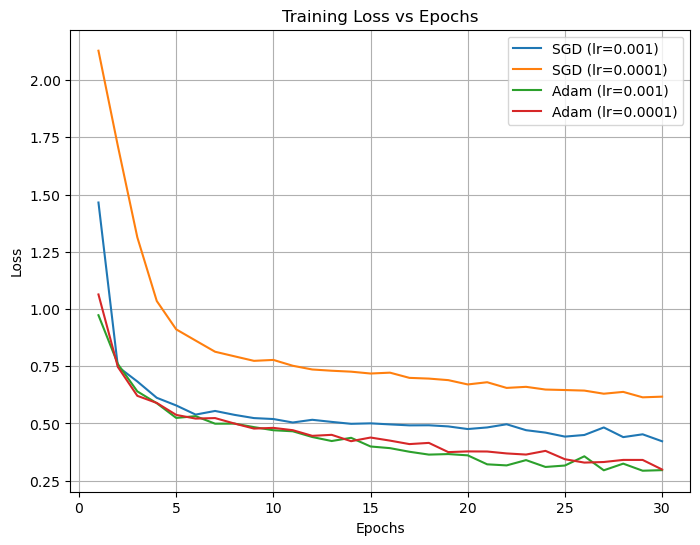

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time

fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "30x0.001xSGD_results_00-11-23-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="SGD")
results_path = "models_results/" + "30x0.0001xSGD_results_27-45-22-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="SGD")
results_path = "models_results/" + "30x0.001xAdamx1560_51-07-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Adam")
results_path = "models_results/" + "30x0.0001xAdamx1560_08-50-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Adam")

plt.title("Training Loss vs Epochs")
plt.show()

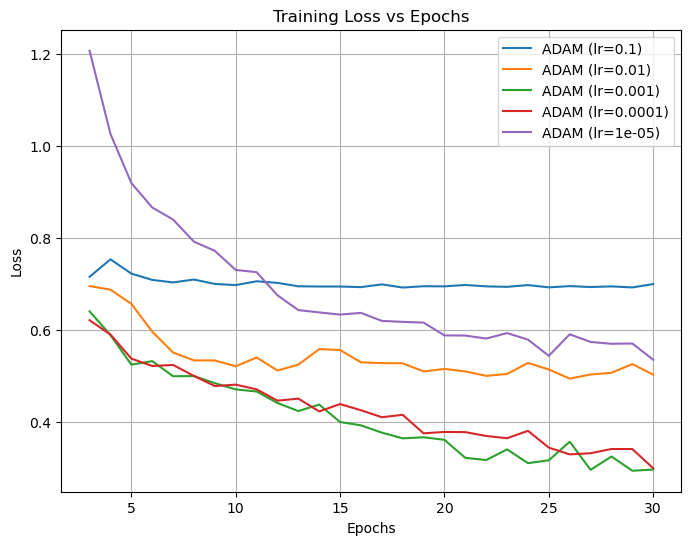

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "30x0.1xAdamx1560_12-24-20-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.01xAdamx1560_12-57-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.001xAdamx1560_51-07-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.0001xAdamx1560_08-50-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x1e-05xAdamx1560_00-29-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)

plt.title("Training Loss vs Epochs")
plt.show()

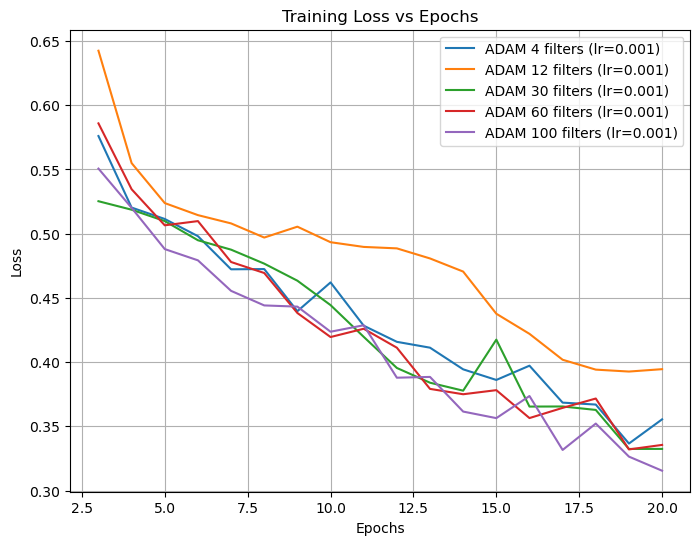

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "4x20x0.001xAdamx1560_27-56-19-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 4 filters", start_epoch=3)
results_path = "models_results/" + "12x20x0.001xAdamx1560_06-35-20-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 12 filters", start_epoch=3)
results_path = "models_results/" + "30x20x0.001xAdamx1560_21-58-20-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 30 filters", start_epoch=3)
results_path = "models_results/" + "60x20x0.001xAdamx1560_54-21-21-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 60 filters", start_epoch=3)
results_path = "models_results/" + "100x20x0.001xAdamx1560_52-45-21-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 100 filters", start_epoch=3)

plt.title("Training Loss vs Epochs")
plt.show()

In [9]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and training parameters
freq_bins = 64
time_steps = 64
lr = 0.001  
num_epochs = 100  
batch_size = 32


model = Net(freq_bins, time_steps).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


optimizer_name = "Adam"
metadata = {
    "model": str(model),
    "freq_bins": freq_bins,
    "time_steps": time_steps,
    "batch_size": batch_size,
    "optimizer": optimizer_name,
    "loss_function": str(criterion),
    "num_epochs": num_epochs,
}

timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
results_path = f"models_results/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
os.makedirs(os.path.dirname(results_path), exist_ok=True)

training_results = {"metadata": metadata, "data": {}}

print(f"Starting training for {num_epochs} epochs with Adam optimizer...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    training_results["data"][str(epoch + 1)] = {"loss": avg_loss, "lr": optimizer.param_groups[0]["lr"]}

    with open(results_path, "w") as f:
        json.dump(training_results, f, indent=4)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

print(f"Training completed. Results saved in: {results_path}")


Starting training for 100 epochs with Adam optimizer...
Epoch [1/100], Loss: 0.9763
Epoch [2/100], Loss: 0.6751
Epoch [3/100], Loss: 0.5825
Epoch [4/100], Loss: 0.5480
Epoch [5/100], Loss: 0.4965
Epoch [6/100], Loss: 0.4810
Epoch [7/100], Loss: 0.4771
Epoch [8/100], Loss: 0.4717
Epoch [9/100], Loss: 0.4513
Epoch [10/100], Loss: 0.4220
Epoch [11/100], Loss: 0.4207
Epoch [12/100], Loss: 0.4175
Epoch [13/100], Loss: 0.4004
Epoch [14/100], Loss: 0.3757
Epoch [15/100], Loss: 0.3679
Epoch [16/100], Loss: 0.3645
Epoch [17/100], Loss: 0.3349
Epoch [18/100], Loss: 0.3415
Epoch [19/100], Loss: 0.3213
Epoch [20/100], Loss: 0.3436
Epoch [21/100], Loss: 0.3144
Epoch [22/100], Loss: 0.2881
Epoch [23/100], Loss: 0.3214
Epoch [24/100], Loss: 0.2943
Epoch [25/100], Loss: 0.3118
Epoch [26/100], Loss: 0.2836
Epoch [27/100], Loss: 0.2850
Epoch [28/100], Loss: 0.3016
Epoch [29/100], Loss: 0.2994
Epoch [30/100], Loss: 0.2862
Epoch [31/100], Loss: 0.3245
Epoch [32/100], Loss: 0.3040
Epoch [33/100], Loss: 0.2

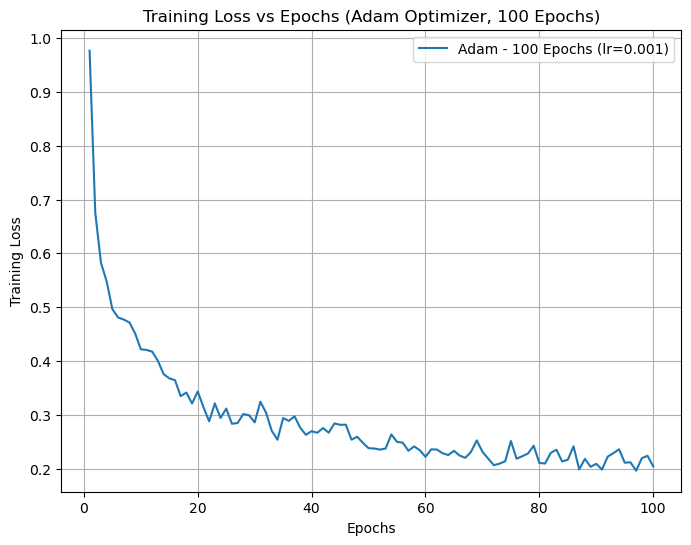

In [17]:
# Plotting the results for the 100-epoch Adam training
fig, ax = plt.subplots(figsize=(8, 6))
results_path = "models_results/" + "100x0.001xAdamx1560_36-07-17-25-01-2025.json"
plot_training_results(ax, results_path, label_prefix="Adam - 100 Epochs")
plt.title("Training Loss vs Epochs (Adam Optimizer, 100 Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.grid(True)
plt.legend()
plt.show()
